In [10]:
pwd

'/home/ec2-user/SealML'

In [1]:
%matplotlib inline
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# Introduction

We have a dataset consisting of seal images and the respective labels for classification, courtesy of the University in Tromsø.

In [2]:
seal_data = sio.loadmat("seal_images.mat")

In [3]:
seal_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'img', 'y'])

In [4]:
seal_data["img"].shape

(1420, 128, 128, 3)

As we can see, we have a very small dataset, consisting of only 1420 sample images. 
This is way too small for training a CNN from scratch

In [5]:
np.unique(seal_data["y"], return_counts=True)

(array([-1,  1]), array([710, 710]))

The dataset is balanced, we have equal number of samples from each class, which is good

We can take a look on some of the images with labels:

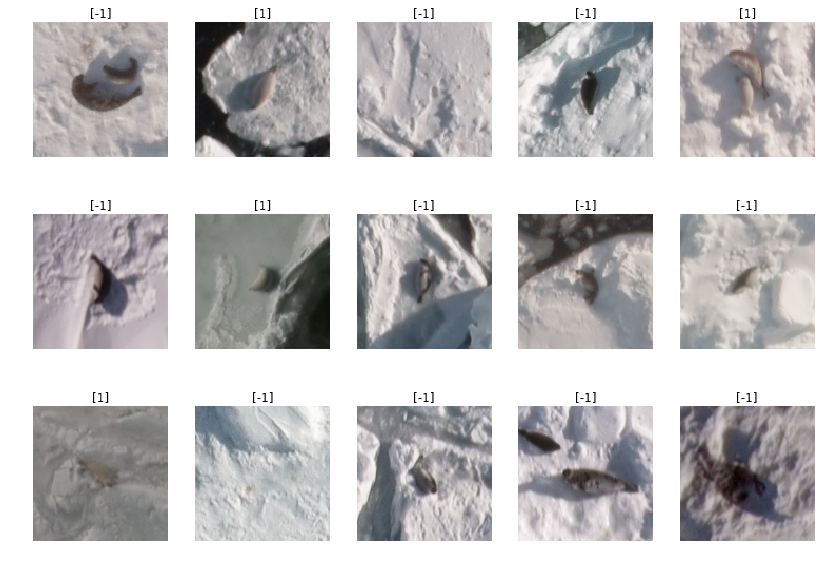

In [117]:
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(14,10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(seal_data["img"][i])
    ax.set_title(seal_data["y"][i])
    ax.axis('off')

The seal images are of harp seal pups and hooded seal pups. We would want to classify these in order to get a more accurate population count.

The images are labeled by The Institute of Marine Research in Norway and the Nortwest Atlantic Fisheries Centre in Canada.

In order to get good classification performance on this small dataset,
we can try to utilize a concept in machine learning called **transfer learning**.

This means that we use the weights of a pre-trained network, often from a very complex architecture.

Then we can fine-tune the weights to our problem in hand.

**Our goals in this notebook are:**

1. Use transfer learning and fine-tuning such that we can get good classification performance on a small dataset
2. Write a 2-layer neural network from scratch in NumPy, in which we use the weights from the fine-tuned network to classify.

We could of course use the same network as in #1 to classify as well, but it is a nice exercise to write a neural network from scratch

*We are going to use the deep learning framework Keras with a TensorFlow-backend to fine-tune a network.*

# Transfer learning and fine tuning of a complex network

ImageNet from Google is a popular network to use

In [22]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import binary_crossentropy

In [12]:
vgg16_model = keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 36s 0us/step


In [13]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
type(vgg16_model)

keras.engine.training.Model

In [15]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [17]:
model.layers.pop()

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [19]:
for layer in model.layers:
    layer.trainable = False

In [20]:
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [119]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In order for the data to fit in the architecture that we have downloaded, we need to resize our images such that they
fit the shape of the input layer. As we can read of the summary above, the input layer expects images in the shape of *(224, 224, 3)*, while our images have the shape *(128, 128, 3)* as we have seen earlier.

We can use the library OpenCV to resize the images for us

In [25]:
import cv2

In [100]:
for image in seal_data["img"]:
    value = cv2.resize(image, (224, 224))
    seal_data.setdefault("img_resized", []).append(value)
    
seal_data["img_resized"] = np.asarray(seal_data["img_resized"])

In [103]:
seal_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'img', 'y', 'img_resized'])

In [101]:
seal_data["img_resized"].shape

(1420, 224, 224, 3)

In [102]:
seal_data["img"].shape

(1420, 128, 128, 3)

In [114]:
def display_image_in_actual_size(im_data):

    dpi = 80
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

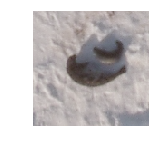

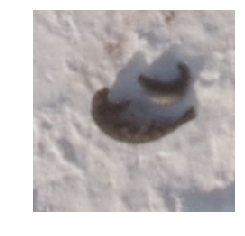

In [116]:
display_image_in_actual_size(seal_data["img"][0])
display_image_in_actual_size(seal_data["img_resized"][0])

And as we can see, we have managed to resize our images to fit the VGG16-architecture.

Now, we just need to further split our dataset into a training, validation and test set.
This is crucial in order to avoid overfitting etc.

Since we want to create a neural network from scratch later, we need to have some data we can use then.
So we will use 30% of the images to fine-tune the VGG16 network, and after that, we will run the remaining images through
the network to get the activations which we can use as a input to our hand-crafted neural network.

In [122]:
from sklearn.model_selection import train_test_split

In [127]:
X_nn_scratch, X_finetune, y_nn_stratch, y_finetune = train_test_split(seal_data["img_resized"], seal_data["y"],
                                                    stratify=seal_data["y"], 
                                                    test_size=0.3)

In [128]:
X_train, X_val, y_train, y_val = train_test_split(X_finetune, y_finetune,
                                                    stratify=y_finetune, 
                                                    test_size=0.2)

In [131]:
y_train = np.where(y_train == 1, y_train, 0)

In [133]:
y_val = np.where(y_val == 1, y_val, 0)

In [136]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, verbose=2, validation_data=(X_val, y_val))

Train on 340 samples, validate on 86 samples
Epoch 1/10
 - 95s - loss: 0.6933 - acc: 0.4706 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 2/10
 - 10s - loss: 0.6923 - acc: 0.5588 - val_loss: 0.6918 - val_acc: 0.6047
Epoch 3/10
 - 11s - loss: 0.6915 - acc: 0.5853 - val_loss: 0.6909 - val_acc: 0.5698
Epoch 4/10
 - 10s - loss: 0.6905 - acc: 0.6029 - val_loss: 0.6898 - val_acc: 0.6279
Epoch 5/10
 - 11s - loss: 0.6894 - acc: 0.6441 - val_loss: 0.6888 - val_acc: 0.6860
Epoch 6/10
 - 11s - loss: 0.6885 - acc: 0.6500 - val_loss: 0.6881 - val_acc: 0.6628
Epoch 7/10
 - 11s - loss: 0.6878 - acc: 0.6529 - val_loss: 0.6876 - val_acc: 0.6860
Epoch 8/10
 - 11s - loss: 0.6871 - acc: 0.6794 - val_loss: 0.6870 - val_acc: 0.7209
Epoch 9/10
 - 11s - loss: 0.6869 - acc: 0.6912 - val_loss: 0.6865 - val_acc: 0.7093
Epoch 10/10
 - 11s - loss: 0.6869 - acc: 0.6176 - val_loss: 0.6869 - val_acc: 0.5930


In [137]:
model.save('sealMLv0.2.h5')